<a href="https://colab.research.google.com/github/chipsalliance/silicon-notebooks/blob/main/xls-adder-openlane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XLS adder with OpenLane

```
Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run a simple 1-bit adder design using the [XLS](https://google.github.io/xls/) high level synthesis toolkit thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the open source [SKY130](https://github.com/google/skywater-pdk/) PDK.

In [ ]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

xls_version = 'latest' #@param {type:"string"}
openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if xls_version == 'latest':
  xls_version = ''
if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        xls={xls_version} \
                        openlane={openlane_version} \
                        open_pdks.sky130a={open_pdks_version}
!python -m pip install gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


## Write and test DSLX module


In [7]:
%%bash -c 'cat > adder.x; interpreter_main adder.x'

pub fn adder(in1: u1, in2: u1) -> u2 {
  let sum: u2 = in1 as u2 + in2 as u2;
  sum
}

#[test]
fn adder_test() {
  let _= assert_eq(adder(u1:0, u1:0), u2:0b00);
  let _= assert_eq(adder(u1:0, u1:1), u2:0b01);
  let _= assert_eq(adder(u1:1, u1:1), u2:0b10);
  _
}

[ RUN UNITTEST  ] adder_test
[            OK ]
[===============] 1 test(s) ran; 0 failed; 0 skipped.


## Generate IR and Verilog

In [8]:
design = 'adder'
!ir_converter_main --top={design} {design}.x > {design}.ir
!opt_main {design}.ir > {design}_opt.ir
!codegen_main --generator=combinational {design}_opt.ir > {design}.v
!cat {design}.v

module __adder__adder(
  input wire in1,
  input wire in2,
  output wire [1:0] out
);
  wire [1:0] sum;
  assign sum = {1'h0, in1} + {1'h0, in2};
  assign out = sum;
endmodule


## Run OpenLane Flow

In [ ]:
%%writefile config.json
{
    "DESIGN_NAME": "__adder__adder",
    "VERILOG_FILES": "dir::adder.v",
    "CLOCK_TREE_SYNTH": false,
    "CLOCK_PORT": null,
    "PL_RANDOM_GLB_PLACEMENT": true,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 34.5 57.12",
    "PL_TARGET_DENSITY": 0.75,
    "FP_PDN_AUTO_ADJUST": false,
    "FP_PDN_VPITCH": 25,
    "FP_PDN_HPITCH": 25,
    "FP_PDN_VOFFSET": 5,
    "FP_PDN_HOFFSET": 5,
    "DIODE_INSERTION_STRATEGY": 3
}

In [11]:
%env PDK=sky130A
!flow.tcl -design . -to synthesis

env: PDK=sky130A
OpenLane 2022.11.02_0_ga0b19fa-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 5d4986783eeb354cc5ba490ae0b17750dd5cb9d3, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: 3534b7999480ed97b9311d2dd95231e54577adc5, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

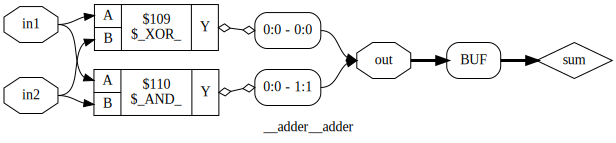

In [12]:
import graphviz
import pathlib

dot = sorted(pathlib.Path('runs').glob('*/tmp/synthesis/post_techmap.dot'))
graphviz.Source.from_file(dot[-1])

In [13]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2022.11.02_0_ga0b19fa-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 5d4986783eeb354cc5ba490ae0b17750dd5cb9d3, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: 3534b7999480ed97b9311d2dd95231e54577adc5, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

## Display layout

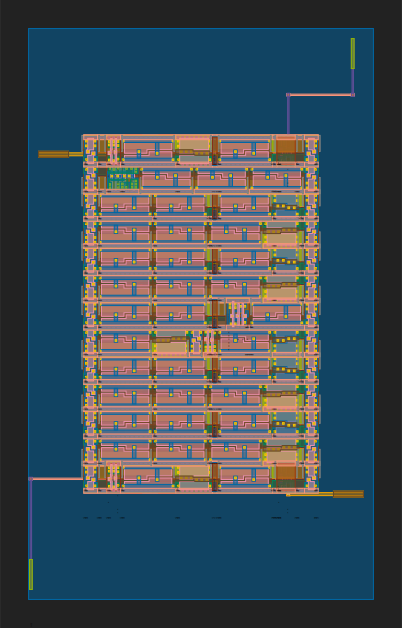

In [14]:
import gdstk
from IPython.display import SVG

gds = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gds[-1])
top_cells = library.top_level()
top_cells[0].write_svg(f'{design}.svg')
SVG(f'{design}.svg')

# Dump flow report

In [15]:
import pandas as pd

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,__adder__adder
config,RUN_2022.11.11_08.06.40
flow_status,flow completed
total_runtime,0h0m35s0ms
routed_runtime,0h0m21s0ms
(Cell/mm^2)/Core_Util,-2.0
DIEAREA_mm^2,0.001971
CellPer_mm^2,-1
OpenDP_Util,-1
